🎨 ## Global Settings & Parameters

Here we define the basic setup for our project: file locations, labels for our categories (Steps, Vehicle, Noise), and settings for how we process the sound signals and extract features. We also load the best settings found from previous experiments to guide our model training.

- **`device`**: Checks if we have a powerful GPU to use, otherwise uses the standard CPU.
- **`CLASS_NAMES`**: The names of the categories we want to identify.
- **`window_size`, `fs`, `stride`**: How we chop the sound signal into smaller, manageable pieces.
- **`NUM_STAT_FEATURES`, `IMG_HEIGHT`, `IMG_WIDTH`**: Details about the 'fingerprints' (features) we create from each sound piece.
- **`DATA_DIR`**: The folder where all our raw sound files (`.csv`) are stored.
- **`INPUT_FILES_LABELS`**: A list matching each sound file to its correct label (Steps, Vehicle, or Noise).
- **`VALIDATION_SPLIT_RATIO`**: We'll set aside 20% of the data just for testing how well the model learned, keeping it separate from the training data.
- **`SAVE_PATH_BASE`**: Where the trained model and results will be saved.
- **`BEST_PARAMS`**: The 'secret sauce' settings (like learning rate) that worked best before.
- **`FINAL_EPOCHS`, `FINAL_BATCH_SIZE`**: How long to train the model and how much data to look at in each step.

1

In [1]:
# --- Core Libraries ---
import numpy as np
import pandas as pd
import os
import glob
import time
import random
from copy import deepcopy
import pickle
import warnings
import cv2
# --- PyTorch Libraries ---
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

# --- Scikit-learn & Imblearn Libraries ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE # !pip install imbalanced-learn

# --- Signal Processing & Feature Extraction ---
from scipy.signal import butter, filtfilt, spectrogram
import librosa
# !pip install librosa

# --- Visualization Libraries ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Configuration ---
warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid", palette="muted") # Use seaborn's themes
plt.rcParams['figure.dpi'] = 90 # Adjust DPI for notebook view
plt.rcParams['figure.figsize'] = (6, 3) # Default smaller figure size

2

In [2]:
# ======================== Device ========================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_workers = min(8, os.cpu_count()) if device.type == 'cuda' else 0
print(f"Device: {device}, Workers: {num_workers}")

# ======================== Labels ========================
LABEL_STEPS    = 0; LABEL_VEHICLE  = 1; LABEL_NOISE    = 2
CLASS_NAMES    = ["Steps", "Vehicle", "Noise"]; NUM_CLASSES    = len(CLASS_NAMES)
print(f"Classes: {CLASS_NAMES}")

# ================= Signal Processing ==================
window_size    = 2000; fs = 1000.0; stride = 250
max_channels   = 37; lowcut = 1.0; highcut = 100.0; order = 4

# ================= Feature Extraction =================
NUM_BASE_FEATURES = 8; NUM_MFCC_FEATURES = 13
NUM_STAT_FEATURES = NUM_BASE_FEATURES + NUM_MFCC_FEATURES # 21
N_FFT = 512; HOP_LENGTH = N_FFT // 4; IMG_HEIGHT = 224; IMG_WIDTH = 224

# ===================== File Paths =====================
BASE_DIR = "." # Assuming notebook is in project root
DATA_DIR = os.path.join(BASE_DIR, "data") # Put ALL initial csv files here
# --- Define the input files directly ---
INPUT_FILES_LABELS = {
    # File Basename : Label
    "man.csv": LABEL_STEPS,
    "car.csv": LABEL_VEHICLE,
    "car2.csv": LABEL_VEHICLE,
    "car3.csv": LABEL_VEHICLE,
    "car4.csv": LABEL_VEHICLE,
    "noise.csv": LABEL_NOISE,
    "nothing.csv": LABEL_NOISE,
}
MAN2_FOLDER = os.path.join(DATA_DIR, "man2") # הנתיב לתיקיית הצעדים החדשה
MAN2_PATTERN = '*.csv' 
# ================== Train/Val Split ===================
VALIDATION_SPLIT_RATIO = 0.20 # 20% for validation
STRATIFY_SEED = 42 # Seed for reproducible splitting

# ===================== Output Path ====================
RUN_NAME = f"final_run_split_{time.strftime('%Y%m%d_%H%M%S')}"
SAVE_PATH_BASE = os.path.join(BASE_DIR, "saved_models", RUN_NAME)
os.makedirs(SAVE_PATH_BASE, exist_ok=True)
print(f"Output Path: {SAVE_PATH_BASE}")

# =================== Hyperparameters ==================
# Using best from Trial 601 (as defined in previous code)
BEST_PARAMS = {
    "lr": 0.0009025320915332941,"weight_decay": 0.00010440037020653871,
    "dropout_p": 0.48661734818710645, "stat_dim": 128,"comb_dim": 256,
    "specaug_apply": False, "specaug_freq_mask": 35,"specaug_time_mask": 92,
    "specaug_f_masks": 2,"specaug_t_masks": 3,"add_stat_noise": False,
    "stat_feature_noise_std": 0.11978948454559124,"label_smoothing": 7.290046944521044e-06
}
FINAL_EPOCHS = 150; FINAL_PATIENCE = 20; FINAL_BATCH_SIZE = 32
SCHEDULER_PATIENCE = max(1, FINAL_PATIENCE // 3); SCHEDULER_FACTOR = 0.2
print(f"Batch Size: {FINAL_BATCH_SIZE}, Epochs: {FINAL_EPOCHS}, Patience: {FINAL_PATIENCE}")
print("Best Params:", BEST_PARAMS) # Optional: uncomment to see all

Device: cuda, Workers: 8
Classes: ['Steps', 'Vehicle', 'Noise']
Output Path: .\saved_models\final_run_split_20250331_133625
Batch Size: 32, Epochs: 150, Patience: 20
Best Params: {'lr': 0.0009025320915332941, 'weight_decay': 0.00010440037020653871, 'dropout_p': 0.48661734818710645, 'stat_dim': 128, 'comb_dim': 256, 'specaug_apply': False, 'specaug_freq_mask': 35, 'specaug_time_mask': 92, 'specaug_f_masks': 2, 'specaug_t_masks': 3, 'add_stat_noise': False, 'stat_feature_noise_std': 0.11978948454559124, 'label_smoothing': 7.290046944521044e-06}


🛠️ ## Helper Functions

This section holds our 'toolbox' – a collection of functions we'll use repeatedly:
- **`pad_channels`**: Makes sure all data pieces have the same number of 'lanes' (channels), adding empty ones if needed.
- **`create_windows`**: Chops the long sound signals into smaller overlapping windows.
- **`apply_filter`**: Cleans the sound signal, keeping only the most relevant frequencies (like filtering out very high or very low hums).
- **`create_stft_spectrogram`**: Creates a 'picture' of the sound (spectrogram), showing frequencies over time.
- **`extract_statistical_features`**: Calculates numerical summaries of the sound window (like average volume, pitch characteristics).
- **`SpecAugment`**: A data trick (augmentation) that slightly changes the sound pictures during training to make the model more robust.
- **`HybridDataset`**: A custom helper to feed the sound pictures and stats efficiently to PyTorch.
- **`HybridGeoModel`**: The actual brain! This defines our model architecture, combining a smart image reader (EfficientNet) for spectrograms and another network (MLP) for the statistical numbers.
- **`train_epoch_hybrid`, `evaluate_model_hybrid`**: Functions to handle the training process (teaching the model) and evaluation (checking its performance).
- **`save_final_model`**: Saves our trained model.
- **`plot_training_history`, `display_results`**: Functions to create graphs and reports showing how well the model learned and performed.

*(No code output in this cell, just definitions)*

3

In [3]:
# =====================================================================================
# =                           Data Preprocessing Functions                           =
# =====================================================================================
def pad_channels(data, target_channels):
    """Pads or truncates data to have target_channels."""
    if data.ndim == 1: data = data.reshape(-1, 1) # Ensure 2D
    current_channels = data.shape[1]
    if current_channels < target_channels:
        padding = np.zeros((data.shape[0], target_channels - current_channels), dtype=data.dtype)
        data = np.hstack((data, padding))
    elif current_channels > target_channels:
        data = data[:, :target_channels]
    return data

def create_windows(signal, label, window_size=window_size, stride=stride):
    """Creates overlapping windows from the signal."""
    X_windows, y_labels = [], []
    if signal.shape[0] < window_size: return [], []
    for start in range(0, signal.shape[0] - window_size + 1, stride):
        window = signal[start : start + window_size, :]
        X_windows.append(window); y_labels.append(label)
    return X_windows, y_labels

def apply_filter(data, lowcut=lowcut, highcut=highcut, fs=fs, order=order):
    """Applies a Butterworth bandpass filter."""
    try:
        nyquist = 0.5 * fs; low = max(lowcut / nyquist, 1e-6); high = min(highcut / nyquist, 1.0 - 1e-6)
        if low >= high: return data
        b, a = butter(order, [low, high], btype='band')
        if data.shape[0] <= order * 3: return data
        return filtfilt(b, a, data, axis=0)
    except Exception as e: return data

# =====================================================================================
# =                         Feature Extraction Functions                             =
# =====================================================================================
def create_stft_spectrogram(signal_1d, sr=fs, n_fft=N_FFT, hop_length=HOP_LENGTH, lowcut_spec=lowcut, highcut_spec=highcut):
    """Creates a normalized STFT spectrogram within the frequency band."""
    try:
        signal_float = signal_1d.astype(np.float32)
        f, t, Sxx = spectrogram(signal_float, fs=sr, nperseg=n_fft, noverlap=n_fft - hop_length, nfft=n_fft)
        freq_idx = np.where((f >= lowcut_spec) & (f <= highcut_spec))[0]
        if len(freq_idx) == 0: return None
        Sxx_band = Sxx[freq_idx, :]; Sxx_db = 10 * np.log10(Sxx_band + 1e-9)
        min_db, max_db = np.min(Sxx_db), np.max(Sxx_db)
        if max_db - min_db < 1e-9: return np.zeros_like(Sxx_db, dtype=np.float32)
        Sxx_norm = (Sxx_db - min_db) / (max_db - min_db)
        return Sxx_norm.astype(np.float32)
    except Exception as e: return None

def extract_statistical_features(signal_1d, sr=fs, n_mfcc=NUM_MFCC_FEATURES):
    """Extracts various statistical and spectral features using librosa."""
    try:
        signal_float = signal_1d.astype(np.float32); features = []
        features.extend([np.mean(signal_float), np.std(signal_float), np.sqrt(np.mean(signal_float**2))]) # Basic stats
        features.append(np.mean(librosa.feature.zero_crossing_rate(y=signal_float))) # ZCR
        stft_result = librosa.stft(signal_float, n_fft=N_FFT, hop_length=HOP_LENGTH); spec_mag = np.abs(stft_result) # STFT for spectral features
        features.append(np.mean(librosa.feature.spectral_centroid(S=spec_mag, sr=sr)))
        features.append(np.mean(librosa.feature.spectral_bandwidth(S=spec_mag, sr=sr)))
        features.append(np.mean(librosa.feature.spectral_rolloff(S=spec_mag, sr=sr, roll_percent=0.85)))
        features.append(np.mean(librosa.feature.spectral_flatness(S=spec_mag)))
        mfccs_feats = librosa.feature.mfcc(y=signal_float, sr=sr, n_mfcc=n_mfcc); mfccs_mean = np.mean(mfccs_feats, axis=1) # MFCCs
        if mfccs_mean.shape[0] < n_mfcc: mfccs_mean = np.pad(mfccs_mean, (0, n_mfcc - mfccs_mean.shape[0]), mode='constant')
        elif mfccs_mean.shape[0] > n_mfcc: mfccs_mean = mfccs_mean[:n_mfcc]
        features.extend(mfccs_mean)
        final_features = np.array(features, dtype=np.float32)
        if final_features.shape[0] != NUM_STAT_FEATURES: final_features = np.pad(final_features, (0, NUM_STAT_FEATURES - final_features.shape[0]), mode='constant')[:NUM_STAT_FEATURES]
        if np.isnan(final_features).any() or np.isinf(final_features).any(): final_features = np.nan_to_num(final_features, nan=0.0, posinf=0.0, neginf=0.0)
        return final_features
    except Exception as e: return np.zeros(NUM_STAT_FEATURES, dtype=np.float32)

# =====================================================================================
# =                 PyTorch Dataset, Augmentation, and Model Classes               =
# =====================================================================================
class SpecAugment(nn.Module):
    """Applies SpecAugment: frequency and time masking."""
    def __init__(self, freq_mask_param=10, time_mask_param=20, num_freq_masks=1, num_time_masks=1):
        super(SpecAugment, self).__init__()
        self.freq_mask_param = freq_mask_param; self.time_mask_param = time_mask_param
        self.num_freq_masks = num_freq_masks; self.num_time_masks = num_time_masks
    def forward(self, spec):
        if not isinstance(spec, torch.Tensor): raise TypeError("Input Tensor.")
        if spec.ndim != 3: raise ValueError("Input Spectrogram must be 3D (C, F, T).")
        spec_aug = spec.clone(); _, F, T = spec_aug.shape
        for _ in range(self.num_freq_masks):
            f = random.randrange(0, self.freq_mask_param + 1);
            if F - f < 0 : continue; f0 = random.randrange(0, F - f + 1)
            spec_aug[:, f0 : f0 + f, :] = spec_aug.mean()
        for _ in range(self.num_time_masks):
            t = random.randrange(0, self.time_mask_param + 1)
            if T - t < 0 : continue; t0 = random.randrange(0, T - t + 1)
            spec_aug[:, :, t0 : t0 + t] = spec_aug.mean()
        return spec_aug

class HybridDataset(Dataset):
    """Custom PyTorch Dataset for hybrid Spectrogram + Statistical features."""
    def __init__(self, specs, stat_feats, labels, transform=None, add_noise=False, noise_std=0.01):
        self.specs = np.asarray(specs, dtype=np.float32); self.stat_feats = np.asarray(stat_feats, dtype=np.float32)
        self.labels = np.asarray(labels, dtype=np.int64); self.transform = transform
        self.add_noise = add_noise; self.noise_std = noise_std
        assert len(self.specs) == len(self.stat_feats) == len(self.labels), "Data length mismatch"
        if len(self.stat_feats) > 0: assert self.stat_feats.shape[1] == NUM_STAT_FEATURES, f"Stat features dim mismatch: Expected {NUM_STAT_FEATURES}, Got {self.stat_feats.shape[1]}"
    def __len__(self): return len(self.labels)
    def __getitem__(self, idx):
        spec = self.specs[idx]; stat_feat_orig = self.stat_feats[idx]; label = self.labels[idx]
        if self.add_noise and self.noise_std > 0:
            noise = np.random.normal(0, self.noise_std, size=stat_feat_orig.shape)
            stat_feat = stat_feat_orig + noise.astype(stat_feat_orig.dtype)
        else: stat_feat = stat_feat_orig
        spec_tensor = torch.tensor(spec, dtype=torch.float32)
        if self.transform: spec_tensor = self.transform(spec_tensor)
        stat_tensor = torch.tensor(stat_feat, dtype=torch.float32)
        label_tensor = torch.tensor(label, dtype=torch.long)
        return spec_tensor, stat_tensor, label_tensor

class HybridGeoModel(nn.Module):
    """Hybrid Model combining EfficientNet for Spectrograms and MLP for Stats."""
    def __init__(self, num_classes=NUM_CLASSES, dropout_p=0.4, input_stat_features=NUM_STAT_FEATURES, stat_feature_dim=128, combined_dim=256):
        super(HybridGeoModel, self).__init__()
        weights = EfficientNet_B0_Weights.DEFAULT; self.cnn_backbone = efficientnet_b0(weights=weights)
        try: # Get output features of EfficientNet backbone
            original_classifier = self.cnn_backbone.classifier
            if isinstance(original_classifier, nn.Sequential) and len(original_classifier) > 1 and isinstance(original_classifier[1], nn.Linear): cnn_out_features = original_classifier[1].in_features
            elif isinstance(original_classifier, nn.Linear): cnn_out_features = original_classifier.in_features
            else: cnn_out_features = 1280 # Default for B0
        except Exception: cnn_out_features = 1280
        self.cnn_backbone.classifier = nn.Identity() # Remove original classifier
        self.stat_mlp = nn.Sequential( # MLP for statistical features
            nn.LayerNorm(input_stat_features), nn.Linear(input_stat_features, stat_feature_dim * 2), nn.ReLU(), nn.Dropout(dropout_p),
            nn.Linear(stat_feature_dim * 2, stat_feature_dim), nn.ReLU())
        self.dropout = nn.Dropout(dropout_p) # Combined classifier layers
        self.fc_combined = nn.Linear(cnn_out_features + stat_feature_dim, combined_dim)
        self.fc_output = nn.Linear(combined_dim, num_classes)
    def forward(self, spec_input, stat_input):
        cnn_features = self.cnn_backbone(spec_input); stat_features = self.stat_mlp(stat_input)
        combined = torch.cat((cnn_features, stat_features), dim=1)
        x = self.dropout(combined); x = F.relu(self.fc_combined(x)); x = self.dropout(x)
        out = self.fc_output(x); return out

# =====================================================================================
# =                   Training, Evaluation & Utility Functions                       =
# =====================================================================================
def train_epoch_hybrid(model, dataloader, criterion, optimizer, device):
    """Trains the hybrid model for one epoch."""
    model.train(); running_loss = 0.0; correct_predictions = 0; total_samples = 0
    for batch_idx, (specs, stat_feats, labels) in enumerate(dataloader):
        specs, stat_feats, labels = specs.to(device), stat_feats.to(device), labels.to(device)
        optimizer.zero_grad()
        try:
            outputs = model(specs, stat_feats); loss = criterion(outputs, labels)
            loss.backward(); optimizer.step()
            running_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0); correct_predictions += (predicted == labels).sum().item()
        except Exception as e: print(f"Error training batch {batch_idx}: {e}"); continue
    epoch_loss = running_loss / total_samples if total_samples > 0 else 0
    epoch_acc = correct_predictions / total_samples if total_samples > 0 else 0
    return epoch_loss, epoch_acc

@torch.no_grad()
def evaluate_model_hybrid(model, dataloader, criterion, device, is_final_eval=False):
    """Evaluates the hybrid model on a given dataset."""
    model.eval(); running_loss = 0.0; correct_predictions = 0; total_samples = 0
    all_labels = []; all_preds = []
    for specs, stat_feats, labels in dataloader:
        specs, stat_feats, labels = specs.to(device), stat_feats.to(device), labels.to(device)
        try:
            outputs = model(specs, stat_feats)
            if not is_final_eval and criterion: loss = criterion(outputs, labels); running_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0); correct_predictions += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy()); all_preds.extend(predicted.cpu().numpy())
        except Exception as e: print(f"Error evaluating batch: {e}"); continue
    epoch_loss = running_loss / total_samples if total_samples > 0 and not is_final_eval else 0
    epoch_acc = correct_predictions / total_samples if total_samples > 0 else 0
    return epoch_loss, epoch_acc, np.array(all_labels), np.array(all_preds)

def save_final_model(epoch, model, optimizer, scaler, val_loss, val_acc, params, filename):
    """Saves the model checkpoint."""
    print(f"\nSaving checkpoint to {filename} (Epoch {epoch}, ValLoss {val_loss:.4f}, ValAcc {val_acc:.4f})")
    state = {
        'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict(),
        'scaler_params': {'mean': scaler.mean_, 'scale': scaler.scale_, 'n_features': scaler.n_features_in_, 'n_samples': scaler.n_samples_seen_,},
        'val_loss': val_loss, 'val_acc': val_acc, 'best_optuna_params': params,
        'fs': fs, 'window_size': window_size, 'stride': stride, 'max_channels': max_channels, 'num_stat_features': NUM_STAT_FEATURES,
    }
    try: torch.save(state, filename)
    except Exception as e: print(f"Error saving checkpoint: {e}")

def plot_training_history(history, save_dir, prefix=""):
    """Plots and saves the training/validation loss and accuracy curves."""
    history_path = os.path.join(save_dir, f"{prefix}train_history.png")
    print(f"\nSaving training history plot to {history_path}")
    epochs = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(10, 4)) # Slightly larger for history plot
    plt.subplot(1, 2, 1) # Loss
    plt.plot(epochs, history['train_loss'], 'bo-', label='Training Loss', markersize=4)
    if 'val_loss' in history and any(x is not None for x in history['val_loss']): plt.plot(epochs, [l if l is not None else np.nan for l in history['val_loss']], 'ro--', label='Validation Loss', markersize=4)
    plt.title("Loss"); plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.grid(True, linestyle=':')
    plt.subplot(1, 2, 2) # Accuracy
    plt.plot(epochs, history['train_acc'], 'bo-', label='Training Accuracy', markersize=4)
    if 'val_acc' in history and any(x is not None for x in history['val_acc']): plt.plot(epochs, [a if a is not None else np.nan for a in history['val_acc']], 'ro--', label='Validation Accuracy', markersize=4)
    plt.title("Accuracy"); plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.ylim(bottom=0.0, top=1.05); plt.legend(); plt.grid(True, linestyle=':')
    plt.tight_layout();
    try: plt.savefig(history_path); plt.close()
    except Exception as e: print(f"Error saving history plot: {e}"); plt.close()

def display_results(true_labels, pred_labels, dataset_name, save_dir=".", prefix="", class_names=CLASS_NAMES):
    """Calculates, prints, and plots evaluation metrics."""
    print(f"\n--- Results: {dataset_name} ---")
    if not isinstance(true_labels, (list, np.ndarray)) or not isinstance(pred_labels, (list, np.ndarray)) or len(true_labels)==0 or len(true_labels) != len(pred_labels): print("Invalid input for display_results."); return
    try:
        true_labels_int = np.asarray(true_labels).astype(int); pred_labels_int = np.asarray(pred_labels).astype(int)
        accuracy = accuracy_score(true_labels_int, pred_labels_int); print(f"Accuracy: {accuracy:.4f}")
        target_labels = list(range(len(class_names)))
        print("\nClassification Report:"); print(classification_report(true_labels_int, pred_labels_int, target_names=class_names, labels=target_labels, zero_division=0))
        print("\nConfusion Matrix:"); cm = confusion_matrix(true_labels_int, pred_labels_int, labels=target_labels); print(cm)
        plt.figure(figsize=(5, 4)) # Smaller CM plot
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names, cbar=False)
        plt.title(f"{dataset_name}\nAcc: {accuracy:.4f}"); plt.ylabel("True"); plt.xlabel("Predicted"); plt.tight_layout()
        cm_path = os.path.join(save_dir, f"{prefix}{dataset_name}_CM.png");
        try: plt.savefig(cm_path); print(f"CM saved: {cm_path}"); plt.close()
        except Exception as e: print(f"Err saving CM: {e}"); plt.close()
    except Exception as e: print(f"Err display results: {e}")
    finally: print("-" * 40)

💾 ## Load Raw Signal Data

Let's load all the initial sound recordings (`.csv` files) listed in `INPUT_FILES_LABELS`.

1.  **Read Files**: Go through each file path.
2.  **Check Columns**: Determine if the file has one column (like `noise.csv`, `car3.csv`, `car4.csv`) or multiple columns.
3.  **Extract Sensor Data**:
    *   If **one column**: Assume it's the sensor data.
    *   If **two or more columns**: Assume the *second* column (index 1) contains the sensor data, ignoring the first (likely time) column.
4.  **Handle Headers**: Attempt to detect and skip a header row if the first row looks non-numeric.
5.  **Clean Up**: Convert the selected column to numbers and remove any invalid entries.
6.  **Store**: Keep the clean signal data (as a NumPy array) along with its label and original filename.
7.  **Visualize**: Show a graph of how long each original recording is.

- **`all_signals_list`**: Stores the loaded data as `(signal_data, label, filename)`.
- **`signal_lengths`**: Keeps track of the length of each recording for the graph.

📊 *A histogram showing the distribution of signal lengths will be displayed below.*

4

In [4]:
all_signals_list = [] # List to hold tuples: (signal_array, label, original_filename)
signal_lengths = []

# --- Part 1: Load signals defined explicitly in INPUT_FILES_LABELS ---
print("--- Loading Initial Signals (from INPUT_FILES_LABELS) ---")
for filename_rel, label in INPUT_FILES_LABELS.items():
    filepath = os.path.join(DATA_DIR, filename_rel) # Construct full path
    print(f"Loading: {filename_rel} (Label: {CLASS_NAMES[label]})")
    if not os.path.exists(filepath):
        print(f"  WARNING: File not found at {filepath}. Skipping.")
        continue
    try:
        # Peek to check columns and potentially header
        df_peek = pd.read_csv(filepath, header=None, nrows=5) # Read a few rows
        num_cols = df_peek.shape[1]
        cols_to_use = None
        header_row = None
        col_index_to_check = 0 # Default check first column for header if only one col

        if num_cols >= 2:
            print(f"  Detected {num_cols} columns. Assuming sensor data is in column 1 (the second column).")
            cols_to_use = [1]
            col_index_to_check = 1
        elif num_cols == 1:
            print(f"  Detected 1 column. Assuming this is the sensor data.")
            cols_to_use = [0]
            col_index_to_check = 0
        else:
            print(f"  WARNING: File has {num_cols} columns. Skipping.")
            continue

        # Basic header check on the column we intend to use
        try:
            pd.to_numeric(df_peek.iloc[:, col_index_to_check])
            header_row = None # Assume no header if numeric
        except ValueError:
            header_row = 0 # Assume header if not numeric
            print(f"  Potential header detected in column {col_index_to_check}. Will skip row 0.")
        except IndexError:
             header_row = None # Assume no header on index error

        # Load the actual data
        df = pd.read_csv(filepath, header=header_row, usecols=cols_to_use)
        df.columns = ['sensor_value'] # Force column name

        # Clean data
        df['sensor_value'] = pd.to_numeric(df['sensor_value'], errors='coerce')
        df = df.dropna()

        if not df.empty:
            signal = df['sensor_value'].values # Get numpy array
            # Ensure signal is 2D for consistency before processing later
            if signal.ndim == 1:
                 signal = signal.reshape(-1, 1)
            all_signals_list.append((signal, label, filename_rel))
            signal_lengths.append(len(signal))
            print(f"  Loaded {len(signal)} valid samples (Shape: {signal.shape}).") # Show shape
        else:
            print(f"  WARNING: No valid data after cleaning. Skipping.")

    except pd.errors.EmptyDataError:
        print(f"  WARNING: File {filename_rel} is empty. Skipping.")
    except Exception as e:
        print(f"  ERROR loading or processing {filename_rel}: {e}")


# --- Part 2: Load NEW Multi-File Steps Data (man2 folder) ---
print("\n--- Loading Additional Steps Data (man2 folder) ---")
man2_files = glob.glob(os.path.join(MAN2_FOLDER, MAN2_PATTERN))
print(f"Found {len(man2_files)} files in {MAN2_FOLDER}.")

if not man2_files:
    print("  WARNING: No files found in the man2 folder. Check path and pattern.")
else:
    for filepath in man2_files:
        label = LABEL_STEPS # These are all steps
        filename_rel = os.path.relpath(filepath, DATA_DIR) # Get relative path for logging
        print(f"Loading: {filename_rel} (Label: {CLASS_NAMES[label]})")
        if not os.path.exists(filepath):
             print(f"  WARNING: File {filepath} vanished? Skipping.")
             continue
        try:
            # Load ALL columns, assuming no header for these specific files
            df = pd.read_csv(filepath, header=None)
            num_cols = df.shape[1]
            print(f"  Detected {num_cols} columns.")

            # Convert all columns to numeric, coerce errors, drop rows with any NaNs
            for col in df.columns:
                 df[col] = pd.to_numeric(df[col], errors='coerce')
            df = df.dropna()

            if not df.empty:
                signal = df.values # Get numpy array (will have multiple columns)
                all_signals_list.append((signal, label, filename_rel))
                signal_lengths.append(len(signal))
                print(f"  Loaded {len(signal)} valid samples (Shape: {signal.shape}).") # Show shape
            else:
                print(f"  WARNING: No valid data after cleaning. Skipping.")

        except pd.errors.EmptyDataError:
            print(f"  WARNING: File {filename_rel} is empty. Skipping.")
        except Exception as e:
            print(f"  ERROR loading or processing {filename_rel}: {e}")

# --- Final Summary and Visualization ---
print("-" * 40)
print(f"Total signals loaded: {len(all_signals_list)}")
if not all_signals_list:
    raise ValueError("CRITICAL: No signals were loaded successfully.")



--- Loading Initial Signals (from INPUT_FILES_LABELS) ---
Loading: man.csv (Label: Steps)
  Detected 37 columns. Assuming sensor data is in column 1 (the second column).
  Loaded 34001 valid samples (Shape: (34001, 1)).
Loading: car.csv (Label: Vehicle)
  Detected 12 columns. Assuming sensor data is in column 1 (the second column).
  Loaded 16998 valid samples (Shape: (16998, 1)).
Loading: car2.csv (Label: Vehicle)
  Detected 12 columns. Assuming sensor data is in column 1 (the second column).
  Loaded 30000 valid samples (Shape: (30000, 1)).
Loading: car3.csv (Label: Vehicle)
  Detected 1 column. Assuming this is the sensor data.
  Loaded 1048575 valid samples (Shape: (1048575, 1)).
Loading: car4.csv (Label: Vehicle)
  Detected 1 column. Assuming this is the sensor data.
  Loaded 60002 valid samples (Shape: (60002, 1)).
Loading: noise.csv (Label: Noise)
  Detected 1 column. Assuming this is the sensor data.
  Loaded 306850 valid samples (Shape: (306850, 1)).
Loading: nothing.csv (Labe

✂️ ## Train/Validation Split

To fairly evaluate our model later, we need to split our loaded signals into two groups:
1.  **Training Set (~80%)**: The data the model will learn from.
2.  **Validation Set (~20%)**: Data the model *never* sees during training, used only to check performance and prevent cheating (overfitting).

We use `stratify` to ensure both sets have a similar mix of Steps, Vehicle, and Noise signals, making the split representative.

- **`train_signals_split`**: List of `(signal, label, filename)` for training.
- **`val_signals_split`**: List of `(signal, label, filename)` for validation.

📊 *Bar charts showing the number of signals per class in each set (Train vs. Validation) will be displayed below.*

5


--- Splitting 361 Signals (20% Validation) ---
Using stratification seed: 42
Split complete:
  Training signals: 288
  Validation signals: 73


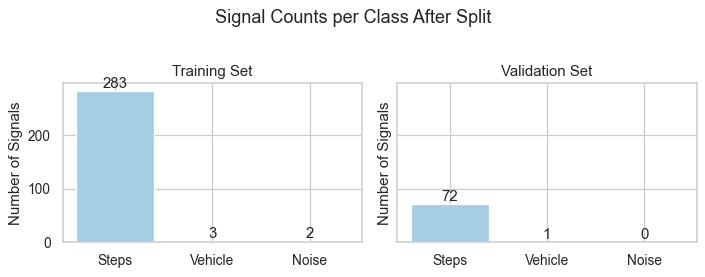

In [5]:
# Prepare lists for splitting
signals_data = [item[0] for item in all_signals_list] # Just the numpy arrays
signals_labels = [item[1] for item in all_signals_list]
signals_filenames = [item[2] for item in all_signals_list]

print(f"\n--- Splitting {len(signals_data)} Signals ({VALIDATION_SPLIT_RATIO*100:.0f}% Validation) ---")
print(f"Using stratification seed: {STRATIFY_SEED}")

# Perform the split
# We split the indices to easily keep track of associated data
indices = list(range(len(signals_labels)))
train_indices, val_indices = train_test_split(
    indices,
    test_size=VALIDATION_SPLIT_RATIO, # Specify validation size
    random_state=STRATIFY_SEED,
    stratify=signals_labels, # <<< Crucial for maintaining class balance
    shuffle=True
)

# Create the final train/validation lists using the indices
# Each list will contain tuples of (signal_array, label, original_filename)
train_signals_split = [all_signals_list[i] for i in train_indices]
val_signals_split = [all_signals_list[i] for i in val_indices]

print(f"Split complete:")
print(f"  Training signals: {len(train_signals_split)}")
print(f"  Validation signals: {len(val_signals_split)}")

# --- Visualize Post-Split Counts Per Class ---
train_split_labels = [item[1] for item in train_signals_split]
val_split_labels = [item[1] for item in val_signals_split]

fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
fig.suptitle("Signal Counts per Class After Split", y=1.02)

def plot_split_counts(labels, title, ax):
    counts = np.bincount(labels, minlength=NUM_CLASSES)
    bars = ax.bar(CLASS_NAMES, counts, color=plt.cm.Paired.colors)
    ax.set_title(title)
    ax.set_ylabel("Number of Signals")
    ax.bar_label(bars)

plot_split_counts(train_split_labels, "Training Set", axes[0])
plot_split_counts(val_split_labels, "Validation Set", axes[1])
plt.tight_layout()
plt.show()

⚙️ ## Data Processing: Windowing & Feature Extraction (Post-Split)

Now we take the raw signals from both the Training and Validation sets and process them into the format our model understands:

1.  **Filter & Pad**: Clean each signal and ensure it has `max_channels`.
2.  **Windowing**: Chop the signals into `window_size` chunks with overlap (`stride`).
3.  **Feature Extraction (Per Window)**:
    *   Calculate the **Spectrogram** (sound picture) from the first channel.
    *   Resize the spectrogram to `IMG_HEIGHT` x `IMG_WIDTH`.
    *   Make it 3-channel (like an RGB image) for the CNN.
    *   Calculate the **Statistical Features** (numbers summarizing the sound) from the first channel.
4.  **Store Features**: Collect all the spectrograms, statistical features, and their corresponding labels for both training and validation sets.

- **`X_spec_train_raw`, `X_stat_train_raw`, `y_train_raw`**: Features and labels for training.
- **`X_spec_val`, `X_stat_val`, `y_val`**: Features and labels for validation.

📊 *Bar charts showing the number of resulting *windows* per class for each set will be displayed below.*

6


--- Processing Signals for Training Set ---
 Proc signal 288/288 (man2\P6_Shoe1_01.csv)......
Finished processing Training:
  Total windows processed: 15111
  Total windows skipped: 0

--- Processing Signals for Validation Set ---
 Proc signal 73/73 (man2\P7_Shoe4_05.csv)......
Finished processing Validation:
  Total windows processed: 2609
  Total windows skipped: 0
----------------------------------------
Processed Training Data Shapes:
  Specs: (15111, 3, 224, 224)
  Stats: (15111, 21)
  Labels: (15111,)

Processed Validation Data Shapes:
  Specs: (2609, 3, 224, 224)
  Stats: (2609, 21)
  Labels: (2609,)


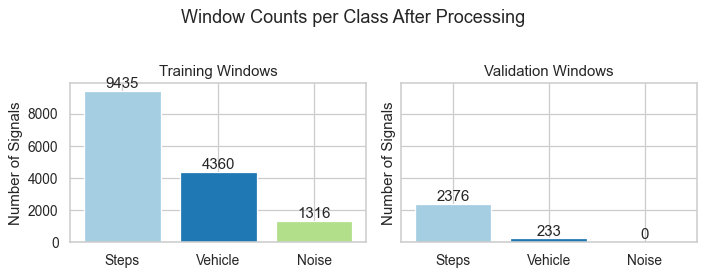

----------------------------------------


In [6]:


def process_signals_split(signal_label_list, dataset_name=""):
    """Applies filtering, padding, windowing, and feature extraction to a list of (signal, label, filename) tuples."""
    all_specs, all_stat_features, all_window_labels = [], [], []
    total_windows_processed = 0; skipped_windows = 0
    print(f"\n--- Processing Signals for {dataset_name} Set ---")
    if not signal_label_list: print("No signals to process."); return [], [], []

    num_signals = len(signal_label_list)
    for idx, (signal_orig, label, fname) in enumerate(signal_label_list):
        print(f" Proc signal {idx+1}/{num_signals} ({fname})...", end='\r') # Less verbose output
        filtered_signal = apply_filter(signal_orig)
        if filtered_signal.shape[0] < window_size: skipped_windows += (filtered_signal.shape[0] // stride) if stride > 0 else 1; continue # Estimate skipped windows
        padded_signal = pad_channels(filtered_signal, max_channels)
        windows, window_labels = create_windows(padded_signal, label)
        if not windows: continue

        for i, w in enumerate(windows):
            try:
                signal_1d = w[:, 0]
                spec = create_stft_spectrogram(signal_1d, sr=fs, n_fft=N_FFT, hop_length=HOP_LENGTH)
                if spec is None: skipped_windows += 1; continue
                resized_spec = cv2.resize(spec, (IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_LINEAR)
                spec_3ch = np.stack([resized_spec] * 3, axis=0)
                stat_feats = extract_statistical_features(signal_1d, sr=fs, n_mfcc=NUM_MFCC_FEATURES)
                if np.isnan(stat_feats).any() or stat_feats.shape[0] != NUM_STAT_FEATURES: skipped_windows += 1; continue

                all_specs.append(spec_3ch); all_stat_features.append(stat_feats)
                all_window_labels.append(window_labels[i]); total_windows_processed += 1
            except Exception as e: skipped_windows += 1 # Count errors as skipped

    print(f"\nFinished processing {dataset_name}:")
    print(f"  Total windows processed: {total_windows_processed}")
    print(f"  Total windows skipped: {skipped_windows}")
    return (np.array(all_specs, dtype=np.float32),
            np.array(all_stat_features, dtype=np.float32),
            np.array(all_window_labels, dtype=np.int64))

# --- Process Training and Validation Signals ---
X_spec_train_raw, X_stat_train_raw, y_train_raw = process_signals_split(train_signals_split, "Training")
X_spec_val, X_stat_val, y_val = process_signals_split(val_signals_split, "Validation") # These are final val features

print("-" * 40)
# --- Verify Shapes & Visualize Window Counts ---
fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
fig.suptitle("Window Counts per Class After Processing", y=1.02)

if len(y_train_raw) > 0:
    print(f"Processed Training Data Shapes:\n  Specs: {X_spec_train_raw.shape}\n  Stats: {X_stat_train_raw.shape}\n  Labels: {y_train_raw.shape}")
    plot_split_counts(y_train_raw, "Training Windows", axes[0])
else: print("No training windows generated.")

if len(y_val) > 0:
    print(f"\nProcessed Validation Data Shapes:\n  Specs: {X_spec_val.shape}\n  Stats: {X_stat_val.shape}\n  Labels: {y_val.shape}")
    plot_split_counts(y_val, "Validation Windows", axes[1])
else: print("No validation windows generated.")

plt.tight_layout(); plt.show()
print("-" * 40)
if len(y_train_raw) == 0: raise ValueError("CRITICAL: No training windows were generated.")

🖼️ ## Data Visualization: Sample Window & Spectrogram

Let's peek at one processed sample from the **training set** to see what the model inputs actually look like. We'll show the spectrogram.

📊 *An image of a sample spectrogram will be displayed below.*

7

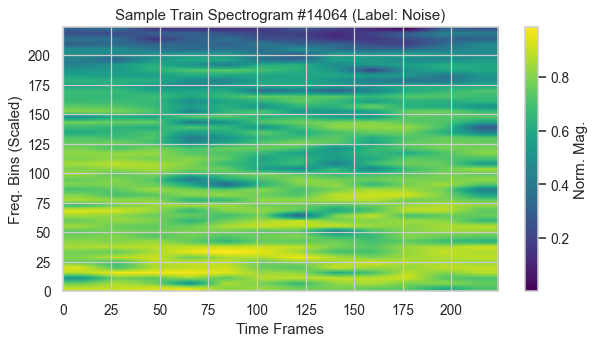

In [7]:
if len(y_train_raw) > 0:
    sample_idx = random.randint(0, len(y_train_raw) - 1)
    sample_spec_3ch = X_spec_train_raw[sample_idx]
    sample_label_idx = y_train_raw[sample_idx]
    sample_label_name = CLASS_NAMES[sample_label_idx]
    sample_spec_1ch = sample_spec_3ch[0, :, :] # Plot first channel

    plt.figure(figsize=(7, 4)) # Slightly larger for spectrogram detail
    plt.imshow(sample_spec_1ch, aspect='auto', origin='lower', cmap='viridis', extent=[0, IMG_WIDTH, 0, IMG_HEIGHT])
    plt.colorbar(label='Norm. Mag.')
    plt.title(f"Sample Train Spectrogram #{sample_idx} (Label: {sample_label_name})")
    plt.xlabel("Time Frames"); plt.ylabel("Freq. Bins (Scaled)")
    plt.tight_layout(); plt.show()
else: print("No training samples to visualize.")

⚖️ ## SMOTE and Feature Scaling

Often, datasets have an unequal number of examples for each category (e.g., lots of Noise, fewer Steps). This can bias the model.

1.  **SMOTE (Synthetic Minority Over-sampling Technique)**: We apply SMOTE *only* to the **training set's statistical features**. It cleverly creates *new*, artificial examples of the less frequent classes (like Steps or Vehicle) to balance things out. We also duplicate the spectrograms corresponding to the original samples that SMOTE used.
2.  **StandardScaler**: We then 'standardize' the statistical features (both training and validation) by adjusting them to have zero mean and unit variance. This helps the model learn more effectively. We fit the scaler *only* on the balanced training data and use it to transform both sets.

- **`X_spec_train_balanced`**: Training spectrograms (with duplications).
- **`X_stat_train_scaled`**: Scaled statistical features for training (after SMOTE).
- **`y_train_smote`**: Training labels (after SMOTE).
- **`X_stat_val_scaled`**: Scaled statistical features for validation.

📊 *A bar chart showing the *window* distribution in the training set *after* SMOTE will be displayed.*

8

In [8]:
print("\n--- Applying SMOTE to Training Statistical Features ---")
X_spec_train_balanced = X_spec_train_raw.copy(); X_stat_train_smote = X_stat_train_raw.copy(); y_train_smote = y_train_raw.copy()
min_samples = np.min(np.bincount(y_train_smote)) if len(y_train_smote) > 0 else 0
if min_samples > 1 and len(np.unique(y_train_smote)) > 1:
    k = min(5, max(1, min_samples - 1)); print(f"Applying SMOTE with k_neighbors={k}")
    smote = SMOTE(random_state=STRATIFY_SEED, k_neighbors=k) # Use same seed for consistency if needed elsewhere
    try:
        X_stat_train_smote, y_train_smote = smote.fit_resample(X_stat_train_raw, y_train_raw)
        print(f" Shape after SMOTE - Stats: {X_stat_train_smote.shape}, Labels: {y_train_smote.shape}")
        num_orig = len(X_spec_train_raw); num_smote = len(y_train_smote)
        if num_smote > num_orig:
            print(f" Duplicating {num_smote - num_orig} spectrograms...")
            duplicate_indices = np.random.choice(num_orig, size=num_smote - num_orig, replace=True)
            specs_to_add = X_spec_train_raw[duplicate_indices]
            X_spec_train_balanced = np.concatenate((X_spec_train_raw, specs_to_add), axis=0)
        elif num_smote < num_orig: print("Warning: SMOTE < original. Using original."); X_spec_train_balanced=X_spec_train_raw; X_stat_train_smote=X_stat_train_raw; y_train_smote=y_train_raw
        if len(X_spec_train_balanced)!=len(X_stat_train_smote) or len(X_spec_train_balanced)!=len(y_train_smote): print("CRITICAL WARNING: Mismatch after SMOTE!"); min_len = min(len(X_spec_train_balanced), len(X_stat_train_smote), len(y_train_smote)); X_spec_train_balanced=X_spec_train_balanced[:min_len]; X_stat_train_smote=X_stat_train_smote[:min_len]; y_train_smote=y_train_smote[:min_len]; print(f" Truncated: {min_len}")
    except ValueError as e: print(f"SMOTE Error: {e}. Using original."); X_spec_train_balanced=X_spec_train_raw; X_stat_train_smote=X_stat_train_raw; y_train_smote=y_train_raw
else: print("Skipping SMOTE."); X_spec_train_balanced=X_spec_train_raw; X_stat_train_smote=X_stat_train_raw; y_train_smote=y_train_raw
print(f"\nFinal Training Set Size (after SMOTE): {len(y_train_smote)} samples.")

# --- Plot Class Distribution AFTER SMOTE ---
plt.figure(figsize=(5, 3)) # Smaller plot for this
ax = plt.gca()
plot_split_counts(y_train_smote, "Training Distribution (After SMOTE)", ax) # Re-use plotting function
plt.tight_layout(); plt.show()

# --- Scale Statistical Features ---
print("\n--- Scaling Statistical Features ---")
scaler = StandardScaler()
print("Fitting Scaler on Training Features..."); X_stat_train_scaled = scaler.fit_transform(X_stat_train_smote)
print(f" Scaler Mean (sample): {scaler.mean_[:3]}"); print(f" Scaler Scale (sample): {scaler.scale_[:3]}")
print("Transforming Validation Features...")
if len(X_stat_val) > 0: X_stat_val_scaled = scaler.transform(X_stat_val); print(" Validation data scaled.")
else: X_stat_val_scaled = np.array([]); print(" No validation data to scale.")
scaler_filepath = os.path.join(SAVE_PATH_BASE, "scaler.pkl");
try: pickle.dump(scaler, open(scaler_filepath, 'wb')); print(f"Scaler saved: {scaler_filepath}")
except Exception as e: print(f"Error saving scaler: {e}")
print("-" * 40)


--- Applying SMOTE to Training Statistical Features ---
Applying SMOTE with k_neighbors=5
 Shape after SMOTE - Stats: (28305, 21), Labels: (28305,)
 Duplicating 13194 spectrograms...


MemoryError: Unable to allocate 7.40 GiB for an array with shape (13194, 3, 224, 224) and data type float32

📦 ## PyTorch Dataset and DataLoader

Time to package our processed data for PyTorch!

1.  **`HybridDataset`**: We use our custom Dataset class to wrap the spectrograms, scaled stats, and labels. It also handles applying transformations (like normalization).
2.  **`DataLoader`**: This efficiently loads data in batches during training/evaluation, shuffles the training data, and can use multiple CPU cores (`num_workers`) to speed things up.

- **`train_dataset`, `val_dataset`**: The packaged datasets.
- **`train_loader`, `val_loader`**: The efficient batch loaders.

9

In [ ]:
print("\n--- Creating PyTorch Datasets and DataLoaders ---")
imagenet_mean=[0.485, 0.456, 0.406]; imagenet_std=[0.229, 0.224, 0.225]
val_transforms = transforms.Compose([transforms.Normalize(mean=imagenet_mean, std=imagenet_std)])
train_transforms_list = []
if BEST_PARAMS["specaug_apply"]: print("Applying SpecAugment."); train_transforms_list.append(SpecAugment(freq_mask_param=BEST_PARAMS["specaug_freq_mask"], time_mask_param=BEST_PARAMS["specaug_time_mask"], num_freq_masks=BEST_PARAMS["specaug_f_masks"], num_time_masks=BEST_PARAMS["specaug_t_masks"]))
else: print("SpecAugment disabled.")
train_transforms_list.append(transforms.Normalize(mean=imagenet_mean, std=imagenet_std))
train_transforms = transforms.Compose(train_transforms_list)
try:
    if len(y_train_smote) == 0: raise ValueError("No training data.")
    train_dataset = HybridDataset(specs=X_spec_train_balanced, stat_feats=X_stat_train_scaled, labels=y_train_smote, transform=train_transforms, add_noise=BEST_PARAMS["add_stat_noise"], noise_std=BEST_PARAMS["stat_feature_noise_std"])
    print(f"Train Dataset: {len(train_dataset)} samples.")
    if len(y_val) > 0: val_dataset = HybridDataset(specs=X_spec_val, stat_feats=X_stat_val_scaled, labels=y_val, transform=val_transforms, add_noise=False); print(f"Validation Dataset: {len(val_dataset)} samples.")
    else: val_dataset = None; print("No validation dataset.")
except Exception as e: raise ValueError(f"Failed dataset creation: {e}") from e

train_loader = DataLoader(train_dataset, batch_size=FINAL_BATCH_SIZE, shuffle=True, num_workers=num_workers, pin_memory=True if device.type == 'cuda' else False, drop_last=(len(train_dataset) > FINAL_BATCH_SIZE))
print(f"Train DataLoader created.")
if val_dataset: val_loader = DataLoader(val_dataset, batch_size=FINAL_BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=True if device.type == 'cuda' else False, drop_last=False); print(f"Validation DataLoader created.")
else: val_loader = None; print("Validation DataLoader not created.")
print("-" * 40)

🧠 ## Model, Optimizer, Loss Setup

Let's get the core components ready for training:

1.  **Model (`HybridGeoModel`)**: Create an instance of our defined hybrid model architecture and move it to the GPU if available.
2.  **Class Weights**: Calculate weights to give more importance to less frequent classes (based on the *post-SMOTE* training distribution) during loss calculation. This further helps balance learning.
3.  **Loss Function (`CrossEntropyLoss`)**: Defines how we measure the model's error. We include the class weights and a small amount of 'label smoothing' to prevent overconfidence.
4.  **Optimizer (`AdamW`)**: The algorithm that adjusts the model's internal parameters to minimize the loss.
5.  **Scheduler (`ReduceLROnPlateau`)**: Automatically reduces the learning rate if the model's performance on the validation set stops improving, helping it fine-tune better.

10

In [ ]:
print("\n--- Setting up Model, Optimizer, and Loss ---")
model = HybridGeoModel(num_classes=NUM_CLASSES, dropout_p=BEST_PARAMS["dropout_p"], input_stat_features=NUM_STAT_FEATURES, stat_feature_dim=BEST_PARAMS["stat_dim"], combined_dim=BEST_PARAMS["comb_dim"]).to(device)
print(f"Model: {model.__class__.__name__}")
if len(y_train_smote) > 0:
    class_counts = np.maximum(np.bincount(y_train_smote, minlength=NUM_CLASSES), 1); total_samples = class_counts.sum()
    class_weights = total_samples / (NUM_CLASSES * class_counts); class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
    print(f"Class Weights: {class_weights_tensor.cpu().numpy()}")
else: class_weights_tensor = None; print("Class weights disabled.")
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor, label_smoothing=BEST_PARAMS["label_smoothing"])
print(f"Loss: CrossEntropyLoss (LS: {BEST_PARAMS['label_smoothing']:.1e})")
optimizer = optim.AdamW(model.parameters(), lr=BEST_PARAMS["lr"], weight_decay=BEST_PARAMS["weight_decay"])
print(f"Optimizer: AdamW (LR: {BEST_PARAMS['lr']:.1e}, WD: {BEST_PARAMS['weight_decay']:.1e})")
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=SCHEDULER_FACTOR, patience=SCHEDULER_PATIENCE, verbose=False) # Less verbose scheduler
print(f"LR Scheduler: ReduceLROnPlateau (Factor: {SCHEDULER_FACTOR}, Patience: {SCHEDULER_PATIENCE})")
print("-" * 40)

🏋️ ## Model Training

Here's where the learning happens!

1.  **Loop**: Repeat the training process for a set number of `FINAL_EPOCHS`.
2.  **Train**: Feed batches of training data through the model, calculate the loss, and update the model's parameters using the optimizer.
3.  **Validate**: After each epoch, feed the *validation* data through the model (without updating parameters) to check its performance on unseen data.
4.  **Track**: Record the loss and accuracy for both training and validation sets.
5.  **Save Best**: If the validation loss improves, save this version of the model as the 'best' one so far.
6.  **Schedule LR**: Adjust the learning rate based on validation performance.
7.  **Early Stopping**: If the validation loss doesn't improve for `FINAL_PATIENCE` epochs, stop training early to prevent overfitting.

- **`history`**: Stores the loss/accuracy values for plotting later.
- **`best_val_loss`**: Tracks the best validation loss seen.
- **`final_model_save_path`**: Path where the best model is saved.

11

In [ ]:
print("\n--- Starting Model Training ---")
best_val_loss = float('inf'); best_epoch = -1; epochs_no_improve = 0
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
final_model_save_path = os.path.join(SAVE_PATH_BASE, f"{RUN_NAME}_best_model.pth")
start_time_training = time.time()
for epoch in range(1, FINAL_EPOCHS + 1):
    epoch_start_time = time.time()
    train_loss, train_acc = train_epoch_hybrid(model, train_loader, criterion, optimizer, device)
    history['train_loss'].append(train_loss); history['train_acc'].append(train_acc)
    val_loss, val_acc = None, None
    if val_loader:
        val_loss, val_acc, _, _ = evaluate_model_hybrid(model, val_loader, criterion, device)
        history['val_loss'].append(val_loss); history['val_acc'].append(val_acc)
    else: history['val_loss'].append(None); history['val_acc'].append(None)
    epoch_duration = time.time() - epoch_start_time
    log_msg = f"Epoch {epoch:03d} [{epoch_duration:.1f}s] Tr L={train_loss:.4f} A={train_acc:.4f}"
    save_model_flag = False
    if val_loader and val_loss is not None:
        log_msg += f" | Val L={val_loss:.4f} A={val_acc:.4f}"
        scheduler.step(val_loss) # Step scheduler on validation loss
        if val_loss < best_val_loss:
             log_msg += f" *Imprv"
             best_val_loss = val_loss; best_epoch = epoch; epochs_no_improve = 0; save_model_flag = True
        else: epochs_no_improve += 1; log_msg += f" ({epochs_no_improve}/{FINAL_PATIENCE})"
    print(log_msg + f" | LR={optimizer.param_groups[0]['lr']:.1e}") # Print LR at end
    if save_model_flag: save_final_model(epoch, model, optimizer, scaler, val_loss, val_acc, BEST_PARAMS, final_model_save_path)
    if val_loader and epochs_no_improve >= FINAL_PATIENCE: print(f"\nEarly stopping @ Epoch {epoch}."); break
    if not val_loader and epoch >= FINAL_EPOCHS: print(f"\nMax epochs reached (no validation).")
total_training_time = time.time() - start_time_training
print(f"\n--- Training Finished ({total_training_time / 60:.2f} min) ---")
if best_epoch != -1: print(f"Best Val Loss: {best_val_loss:.4f} @ Epoch {best_epoch}. Model saved: {final_model_save_path}")
else: print("No best model saved (or no validation).")
print("-" * 40)

📈 ## Training History Visualization

Let's plot the learning curves! These graphs show how the training/validation loss and accuracy changed over the epochs. Helps us see if the model learned well and if it started overfitting.

📊 *Graphs of Loss vs. Epoch and Accuracy vs. Epoch will be displayed below.*

12

In [ ]:
plot_training_history(history, SAVE_PATH_BASE, prefix="final_")

🧪 ## Final Model Evaluation

The moment of truth! Load the **best** model saved during training and evaluate its final performance on the **held-out validation set**.

1.  **Load**: Reload the best model state and the scaler used during training.
2.  **Evaluate**: Run the `evaluate_model_hybrid` function on the `val_loader`.
3.  **Display**: Show the final accuracy, classification report (precision, recall, F1-score per class), and confusion matrix using the `display_results` function.

📊 *A confusion matrix plot for the validation set will be displayed below, along with printed metrics.*

13

In [ ]:
print("\n--- Final Model Evaluation on Held-Out Validation Set ---")
model_loaded = False
if best_epoch != -1 and os.path.exists(final_model_save_path):
    print(f"Loading best model: {final_model_save_path}")
    try:
        checkpoint = torch.load(final_model_save_path, map_location=device)
        # Load Scaler
        eval_scaler = StandardScaler(); eval_scaler.mean_ = checkpoint['scaler_params']['mean']; eval_scaler.scale_ = checkpoint['scaler_params']['scale']
        eval_scaler.n_features_in_ = checkpoint['scaler_params']['n_features']; eval_scaler.n_samples_seen_ = checkpoint['scaler_params']['n_samples']
        assert eval_scaler.n_features_in_ == NUM_STAT_FEATURES, "Scaler mismatch"
        # Load Model
        eval_params = checkpoint.get('best_optuna_params', BEST_PARAMS)
        eval_model = HybridGeoModel(num_classes=NUM_CLASSES, dropout_p=eval_params.get('dropout_p', BEST_PARAMS["dropout_p"]), input_stat_features=eval_scaler.n_features_in_, stat_feature_dim=eval_params.get('stat_dim', BEST_PARAMS["stat_dim"]), combined_dim=eval_params.get('comb_dim', BEST_PARAMS["comb_dim"])).to(device)
        eval_model.load_state_dict(checkpoint['model_state_dict'])
        eval_model.eval(); model_loaded = True; print("Model and scaler loaded.")
    except Exception as e: print(f"ERROR loading checkpoint: {e}")
else: print("Skipping evaluation: Best model not found.")

# --- Evaluate on the val_loader ---
if model_loaded and val_loader:
    print(f"\nEvaluating on Validation Set ({len(val_dataset)} samples)...")
    # We already have the processed validation data in val_loader
    _, _, true_labels_np, pred_labels_np = evaluate_model_hybrid(eval_model, val_loader, None, device, is_final_eval=True)
    display_results(true_labels_np, pred_labels_np, "ValidationSet", SAVE_PATH_BASE, prefix="final_eval_")
elif model_loaded and not val_loader:
     print("\nNo validation data/loader was created during setup to evaluate.")
else:
     print("\nSkipping validation set evaluation as model was not loaded.")
print("\n=== Full Notebook Finished ===")